# Get the info on the number of unique isoforms detected within the smple 


In [1]:


import os
from re import sub


from huvec_analysis import huvec_config, data_loader
import pandas as pd 
import matplotlib.pyplot as plt 
import os 
import matplotlib
matplotlib.rc('font', **huvec_config.font)

# all plots go into a directory
if not os.path.exists('plot'):
    os.makedirs('plot')

# all statistics go into a directory
if not os.path.exists('stats'):
    os.makedirs('stats')


In [2]:

# read in the paths to the sqanti data 
sqanti_info_path = '../00_pre_analysis/sqanti_info/sqanti_info.tsv'
fasta_file = f'{huvec_config.PIPELINE_RESULTS_DIRECTORY}/hybrid_protein_database/huvec_hybrid.fasta'
pacbio_protein_grps_path = '../00_pre_analysis/metamorpheus_table/AllProteinGroups.PacBioHybrid.tsv'
pacbio_peps_path = f'{huvec_config.PIPELINE_RESULTS_DIRECTORY}/metamorpheus/pacbio/hybrid/search_results/Task1SearchTask/AllPeptides.huvec.hybrid.psmtsv'
pacbio_peps_filtered_path = '../00_pre_analysis/metamorpheus_table/AllPeptides.PacBioHybrid.tsv'
gencode_pr_grps_path = f'{huvec_config.PIPELINE_RESULTS_DIRECTORY}/metamorpheus/gencode/search_results/Task1SearchTask/AllQuantifiedProteinGroups.Gencode.tsv'
human_ec_gene_path = f'{huvec_config.REFERENCE_DIRECTORY}/human_ec_genes_from_karen.txt'
#read in the files 
sqanti_info = pd.read_table(sqanti_info_path)
pacbio_pr_grps = pd.read_table(pacbio_protein_grps_path, index_col= False)
pacbio_pr_grps = pacbio_pr_grps.dropna(subset=['Gene'])
# read in the GENCODE protein groups
gencode_pr_grps = pd.read_table(gencode_pr_grps_path, index_col= False)
gencode_pr_grps = gencode_pr_grps.dropna(subset=['Gene'])
human_ec_genes = pd.read_table(human_ec_gene_path, header = None)[0].to_list()


In [3]:
# expand the gene column and split on the |
# pacbio_pr_grps = pacbio_pr_grps.head()
pacbio_pr_grps['gene_list'] = pacbio_pr_grps['Gene'].str.split("|")
pacbio_pr_grps['gene_set'] = pacbio_pr_grps['gene_list'].apply(set)

# so now drop any columns where there is more than 1 value in the set 
def has_multiple(group):
    return len(group) > 1
pacbio_pr_grps['has_mult_isos'] = pacbio_pr_grps['gene_set'].apply(has_multiple)
pacbio_pr_grps['has_mult_isos'] = pacbio_pr_grps['has_mult_isos'].astype(int)
pacbio_pr_grps['gene_name'] = pacbio_pr_grps['Gene'].str.split('|').str[0]
pacbio_pr_grps['ec_priority'] = pacbio_pr_grps['Gene'].isin(human_ec_genes) * 1
#pacbio_pr_grps.to_csv('stats/01_shared_iso.csv', index=False)


In [4]:

# find all the values where has_mult_iso i true 
#multi_mapping_isos = pacbio_pr_grps[pacbio_pr_grps['has_mult_isos']==True]
#multi_mapping_isos.to_csv('stats/shared_iso_is_true')

single_gene_pr_grps_pacbio = pacbio_pr_grps[~pacbio_pr_grps['gene_set'].apply(has_multiple)]
pacbio_num_genes = single_gene_pr_grps_pacbio.groupby('gene_name').agg(number_of_groups=('Gene', 'count'))

# perform the simialar analysis for the gencode protein groups we discovered 
# so now drop any columns where there is more than 1 value in the set 
gencode_pr_grps['gene_list'] = gencode_pr_grps['Gene'].str.split("|")
gencode_pr_grps['gene_set'] = gencode_pr_grps['gene_list'].apply(set)

gencode_pr_grps['has_mult_isos'] = gencode_pr_grps['gene_set'].apply(has_multiple)
gencode_pr_grps['has_mult_isos'] = gencode_pr_grps['has_mult_isos'].astype(int)
gencode_pr_grps['gene_name'] = gencode_pr_grps['Gene'].str.split('|').str[0]
gencode_pr_grps['ec_priority'] = gencode_pr_grps['Gene'].isin(human_ec_genes) * 1

single_gene_pr_grps_gencode = gencode_pr_grps[~gencode_pr_grps['gene_set'].apply(has_multiple)]
gencode_num_genes = single_gene_pr_grps_gencode.groupby('gene_name').agg(number_of_groups=('Gene', 'count'))


In [5]:

# find for how many unique peptide found between pb and gc 
pb_uniq = pacbio_pr_grps[pacbio_pr_grps['Number of Unique Peptides']==1]
gc_uniq = gencode_pr_grps[gencode_pr_grps['Number of Unique Peptides'] == 1]

# look at the peptides file to find all the columns with 1 accession 
pacbio_peps_filtered = pd.read_table(pacbio_peps_filtered_path)

# find the occurences of | within the protein accession column 
def read_peps_file(peps_file):
    peps_table = pd.read_table(pacbio_peps_filtered_path, sep = '\t')
    sub = '|'
    peps_table['unique_isoform'] = peps_table['Protein Accession'].str.find(sub)
    gencode_peps_isoform_resolve = peps_table[peps_table['unique_isoform']== -1]
    return gencode_peps_isoform_resolve
pacbio_peps_filtered = read_peps_file(pacbio_peps_filtered_path)
pacbio_peps_filtered.to_csv('stats/test_isoform_resolve.tsv', sep = '\t')
# find for how many have multi mapping accessions (indicating for how many peps are mapping to multiple isos)


In [6]:

# %%
# read in the pacbio filtered peps 
pacbio_peps_filtered = pd.read_table(pacbio_peps_filtered_path)
pacbio_peps_filtered

# find the | substring within the protein accession 
sub = '|'
pacbio_peps_filtered['unique_isoform'] = pacbio_peps_filtered['Protein Accession'].str.find(sub)
pacbio_peps_filtered['character_count'] = pacbio_peps_filtered['Protein Accession'].str.count('\|')
pacbio_peps_filtered.to_csv('stats/pacbio_peps_unique_isos.tsv', sep = '\t')

# find how many times the unique_isoform does not equal -1
multi_map_isos = pacbio_peps_filtered[pacbio_peps_filtered['unique_isoform']!=-1]
len(multi_map_isos)
multi_map_isos.gene_name.nunique()


4790

In [7]:


# find the number of single mapping isos
single_map_isos = pacbio_peps_filtered[pacbio_peps_filtered['unique_isoform']==-1]
single_map_isos
unique_single_isos = single_map_isos.gene_name.unique()
unique_single_isos_set = set(unique_single_isos)
#%%
pacbio_pr_grps = pd.read_table(pacbio_protein_grps_path)

# find how many unique peptides that were detected 
unique_peps = pacbio_pr_grps[pacbio_pr_grps['Number of Unique Peptides']==1]
unique_peps


,Protein Accession,Gene,Organism,Protein Full Name,Protein Unmodified Mass,Number of Proteins in Group,Unique Peptides,Shared Peptides,Number of Peptides,Number of Unique Peptides,...,Number of PSMs,Protein Decoy/Contaminant/Target,Protein Cumulative Target,Protein Cumulative Decoy,Protein QValue,Best Peptide Score,Best Peptide Notch QValue,accs,genes,gene_name
1,PB.1380.6,CEP170,NaN,NaN,164439.49598048074,1,HQDQAVVFGVDDNQDYNRPVINEK,LGEASDSELADADKASVASEVSTTSSTSKPPTGR|EINDVAGEIDS...,75,1,...,803,T,3,0,0.00000,43.335342,0.000000,['PB.1380.6'],['CEP170'],CEP170
3,PB.974.21,LMNA,NaN,NaN,70618.07029594362,1,TALINSTGEGSHCSSSGDPAEYNLR,TVLCGTCGQPADKASASGSGAQVGGPISSGSSASSVTVTR|SRTVL...,84,1,...,2328,T,5,0,0.00000,42.307367,0.000000,['PB.974.21'],['LMNA'],LMNA
14,SUZ12-201,SUZ12,NaN,NaN,83002.57725346166,1,KTFKVDDMLSK,HGGGGGGGSGPSAGSGGGGFGGSAAVAAATASGGK|LQLLDGEYEV...,20,1,...,126,T,16,0,0.00000,38.479578,0.000000,['SUZ12-201'],['SUZ12'],SUZ12
23,PB.12702.19,RRBP1,NaN,NaN,156787.9639842838,1,AGGVELPGAPGRQDR,SIEALLEAGQARDAQDVQASQAEADQQQTR|KADSVANQGTKVEGI...,85,1,...,1621,T,25,0,0.00000,38.287361,0.000000,['PB.12702.19'],['RRBP1'],RRBP1
29,PB.11450.14,P4HB,NaN,NaN,54652.38295479514,1,MDSTANEVIDYNGER,TGPAATTLPDGAAAESLVESSEVAVIGFFKDVESDSAK|RTGPAAT...,39,1,...,1791,T,31,0,0.00000,38.210022,0.000000,['PB.11450.14'],['P4HB'],P4HB
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9869,TAF11L14-201,TAF11L14,NaN,NaN,21826.760194948885,1,VFVGEVVEEALDMCEMWGEMPPLQPMDLR,NaN,1,1,...,1,T,9974,99,0.00992,10.084589,0.000295,['TAF11L14-201'],['TAF11L14'],TAF11L14
9870,TANC2-205,TANC2,NaN,NaN,NaN,1,LTGDAEQELGPPPSVDEAANTLMTR,LGFLLGEK,2,1,...,6,T,9975,99,0.00992,10.037407,0.000297,['TANC2-205'],['TANC2'],TANC2
9872,PB.11716.3,MIDN,NaN,NaN,41798.11932990384,1,LTAAPSASLLQGQSQIR,NaN,1,1,...,3,T,9977,99,0.00992,9.488188,0.000299,['PB.11716.3'],['MIDN'],MIDN
9874,PB.6205.7,PYCR3,NaN,NaN,27802.31920142928,1,DFTALGIFEASPFADR,MAGAIAQGLIR,2,1,...,4,T,9979,99,0.00992,9.449479,0.000302,['PB.6205.7'],['PYCR3'],PYCR3


In [8]:

# %%
# look at the protein groups file to find the multi-mapping protein accession rows 
pacbio_pr_grps['unique_isoform'] = pacbio_pr_grps['Protein Accession'].str.find(sub)
pacbio_pr_grps['ec_priority'] = pacbio_pr_grps['gene_name'].isin(human_ec_genes) * 1
pacbio_pr_grps.to_csv('stats/pacbio_pr_grp.tsv', '\t')
not_unique_pr_grps = pacbio_pr_grps[pacbio_pr_grps['unique_isoform']!=-1]
len(not_unique_pr_grps)


3975

In [10]:

# %%
# test = unique_single_isos_set.isin(unique_peps['gene_name'])
# %%
#use the data loader files to look to see if I did the gene mapping wrong 
peptides = data_loader.Peptide()

pacbio_peps = peptides.pacbio_hybrid_peptide

sub = '|'
pacbio_peps['unique_isoform'] = pacbio_peps['Protein Accession'].str.find(sub)

base_seq_dups = pacbio_peps_filtered[pacbio_peps_filtered.duplicated(['Protein Accession', 'Base Sequence'])]

pacbio_peps_try2 = pacbio_peps_filtered.drop_duplicates(subset = ['Protein Accession', 'Base Sequence'], keep = 'first')

sub = '|'
pacbio_peps_try2['unique_isoform'] = pacbio_peps_try2['Protein Accession'].str.find(sub)
unique2 = pacbio_peps_try2[pacbio_peps_try2['unique_isoform']==-1]
unique2


<ipython-input-10-41a9ccf70cfb>:5: DtypeWarning: Columns (11) have mixed types.Specify dtype option on import or set low_memory=False.
  peptides = data_loader.Peptide()
<ipython-input-10-41a9ccf70cfb>:5: DtypeWarning: Columns (11) have mixed types.Specify dtype option on import or set low_memory=False.
  peptides = data_loader.Peptide()
<ipython-input-10-41a9ccf70cfb>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pacbio_peps_try2['unique_isoform'] = pacbio_peps_try2['Protein Accession'].str.find(sub)


,File Name,Scan Number,Total Ion Current,Precursor Charge,Score,Base Sequence,Full Sequence,"PSM Count (unambiguous, <0.01 q-value)",Mass Diff (ppm),Protein Accession,...,Decoy/Contaminant/Target,Matched Ion Mass-To-Charge Ratios,Matched Ion Intensities,QValue,accs,genes,gene_name,ec_priority,unique_isoform,character_count
4,"210827_HUVEC5,6_tryp_HCDorbi_4hr_Fr14",163736,347670944.0,4.0,40.314,GTHTGVWVGVSGSETSEALSRDPETLVGYSMVGCQR,GTHTGVWVGVSGSETSEALSRDPETLVGYSMVGC[Common Fixe...,179,-1.71,PB.11465.3,...,T,"[b3+1:296.13477, b4+1:397.18277, b5+1:454.2037...","[b3+1:786233, b4+1:958903, b5+1:667356, b6+1:2...",0.000000,['PB.11465.3'],['FASN'],FASN,0,-1,0
5,"210827_HUVEC5,6_tryp_HCDorbi_4hr_Fr13",262239,12627365.0,4.0,40.299,SFIMGADEALESELGLGELAGLTVANEADSLTYDIANNKDALRK,SFIMGADEALESELGLGELAGLTVANEADSLTYDIANNKDALRK,1,-1.11,STRN-201,...,T,"[b2+1:235.10706, b3+1:348.19112, b4+1:479.2333...","[b2+1:191102, b3+1:164755, b4+1:27002, b6+1:36...",0.000000,['STRN-201'],['STRN'],STRN,0,-1,0
9,"210827_HUVEC5,6_tryp_HCDorbi_4hr_Fr10",53425,10248362.0,3.0,39.240,GGTPGSGAAAAAGSKPPPSSSASASSSSSSFAQQR,GGTPGSGAAAAAGSKPPPSSSASASSSSSSFAQQR,9,-2.58,ARID1A-201,...,T,"[b3+1:216.09758, b4+1:313.15094, b5+1:370.1717...","[b3+1:21724, b4+1:13636, b5+1:55324, b8+1:1809...",0.000000,['ARID1A-201'],['ARID1A'],ARID1A,0,-1,0
10,"210827_HUVEC5,6_tryp_HCDorbi_4hr_Fr14",189565,340588096.0,4.0,39.192,VAIEHLDKISDSVLVDIKDTEPLIQTAK,VAIEHLDKISDSVLVDIKDTEPLIQTAK,142,-1.20,PB.3717.1,...,T,"[b2+1:171.11272, b3+1:284.19724, b5+1:550.3001...","[b2+1:1696984, b3+1:789582, b5+1:1085852, b6+1...",0.000000,['PB.3717.1'],['CCT5'],CCT5,0,-1,0
11,"210827_HUVEC5,6_tryp_HCDorbi_4hr_Fr11",69435,6697902.0,3.0,38.480,HGGGGGGGSGPSAGSGGGGFGGSAAVAAATASGGK,HGGGGGGGSGPSAGSGGGGFGGSAAVAAATASGGK,10,-2.43,SUZ12-201,...,T,"[b2+1:195.08765, b5+1:366.15152, b6+1:423.1726...","[b2+1:22811, b5+1:26028, b6+1:19673, b7+1:3258...",0.000000,['SUZ12-201'],['SUZ12'],SUZ12,0,-1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99924,"210827_HUVEC5,6_tryp_HCDorbi_4hr_Fr11",49351,15688326.0,2.0,8.201,AGLTLMWNR,AGLTLMWNR,2,0.82,MUC2-203,...,T,"[b2+1:129.06485, b3+1:242.14879, b4+1:343.1963...","[b2+1:47440, b3+1:176527, b4+1:171921];[y1+1:9...",0.009979,['MUC2-203'],['MUC2'],MUC2,0,-1,0
99925,"210827_HUVEC5,6_tryp_HCDorbi_4hr_Fr14",159273,24169192.0,4.0,8.201,EGSVARITTSKSFPASLGMCTVR,EGSVARITTSKSFPASLGMC[Common Fixed:Carbamidomet...,2,2.34,MALRD1-204,...,T,"[b2+1:187.07047, b3+1:274.10315];[y1+1:175.118...","[b2+1:67787, b3+1:120650];[y1+1:97304, y6+1:28...",0.009979,['MALRD1-204'],['MALRD1'],MALRD1,0,-1,0
99926,"210827_HUVEC5,6_tryp_HCDorbi_4hr_Fr15",79998,3223649.0,2.0,8.201,VQVPLQTLCTK,VQVPLQTLC[Common Fixed:Carbamidomethyl on C]TK,1,-2.27,PB.4491.3,...,T,"[b2+1:228.13405, b3+1:327.20230];[y3+1:408.191...","[b2+1:238197, b3+1:28776];[y3+1:15022, y5+1:19...",0.009989,['PB.4491.3'],['MRPS18B'],MRPS18B,0,-1,0
99928,"210827_HUVEC5,6_tryp_HCDorbi_4hr_Fr15",50346,4472424.0,2.0,8.201,TIIFVETKR,TIIFVETKR,2,-1.16,DDX17-203,...,T,"[b2+1:215.13882, b3+1:328.22311];[y1+1:175.118...","[b2+1:146563, b3+1:28168];[y1+1:38344, y3+1:26...",0.009999,['DDX17-203'],['DDX17'],DDX17,0,-1,0


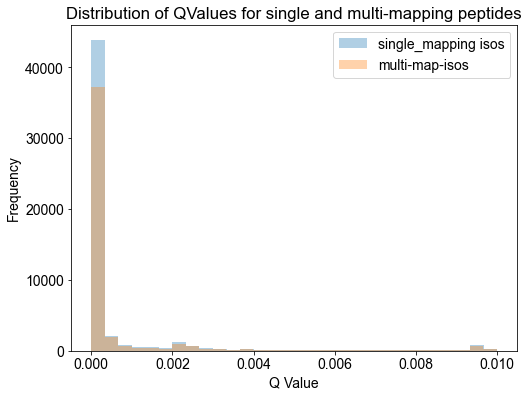

In [11]:


# make an overlay histogram of the q values for the unique vs multi-mapping peps in the allpeps file 
plt.figure(figsize=(8,6))
plt.hist(single_map_isos['QValue'], alpha = 0.35, label= "single_mapping isos", bins=30)
plt.hist(multi_map_isos['QValue'], alpha = 0.35, label = "multi-map-isos", bins = 30)
plt.xlabel("Q Value")
plt.ylabel("Frequency")
plt.title("Distribution of QValues for single and multi-mapping peptides")
plt.legend(loc = 'upper right')
#plt.savefig('plot/overlay_histqvals_single_mulit_map_isos.pdf')


In [13]:

#plt.savefig('plot/overlay_histqvals_single_mulit_map_isos.pdf')
# %%
# table of the peptides found in allpeps but not in AllProteingrps
common = single_map_isos['Base Sequence'].isin(pacbio_pr_grps['Unique Peptides'])

single_map_isos['peptide_is_in_common'] = single_map_isos['Base Sequence'].isin(pacbio_pr_grps['Unique Peptides'])
common_peptide_to_both = single_map_isos[single_map_isos['peptide_is_in_common']==False]
common_peptide_to_both.to_csv('stats/common_peptide_to_both_isFalse.tsv', sep = '\t')
# %%
common_peps_try2 = single_map_isos['peptide_is_in_common'] = single_map_isos['Base Sequence'].isin(pacbio_pr_grps['Unique Peptides'])
#%%
# try to use the BioSeq to parse thru 
# load up the whole protein database into a python dictionary (gene --> protein_accession --> sequence)
#  Then for each peptide, determine which gene/protein_accession(s) it maps to. 
# Would store the mapping information in another table.

toy_peps = pacbio_peps_filtered.head(10)

<ipython-input-13-ac95172e458b>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  single_map_isos['peptide_is_in_common'] = single_map_isos['Base Sequence'].isin(pacbio_pr_grps['Unique Peptides'])
<ipython-input-13-ac95172e458b>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  common_peps_try2 = single_map_isos['peptide_is_in_common'] = single_map_isos['Base Sequence'].isin(pacbio_pr_grps['Unique Peptides'])
